<a href="https://colab.research.google.com/github/Axelxqy/Sentiment_Analysis/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Sentiment Analysis
Using the data from the website, https://huggingface.co/datasets/Sp1786/multiclass-sentiment-analysis-dataset

We are using it to:
1. Find the accuracy and confusion matrix of the pre existing data
2. Create a whole new labels for the data, then find the accuracy and confusion matrix of it (Optional)





# LSTM Model with GloVe Pretrain Model

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from google.colab import files

In [ ]:
uploaded = files.upload()

filename = list(uploaded.keys())[0]

#Read in data
df = pd.read_csv(filename)

Saving OriginalData.csv to OriginalData (3).csv


In [ ]:
# Remove NaN values
df.dropna(inplace=True)

# Convert labels to numerical format if not already
label_map = {"negative": 0, "neutral": 1, "positive": 2}
df['sentiment'] = df['sentiment'].map(label_map)

In [ ]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df["text"], df["sentiment"], test_size=0.3, random_state=42)


In [ ]:
# Tokenize text
max_words = 10000  # Maximum number of words in vocabulary
max_len = 100  # Max sequence length per sentence

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df['text'])

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [ ]:
# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding="post", truncating="post")
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding="post", truncating="post")

In [ ]:
# Choose one:
# oversample = RandomOverSampler(sampling_strategy='auto')  # Oversample minority classes
undersample = RandomUnderSampler(sampling_strategy='auto')  # Undersample majority class

# Resample dataset
X_train_resampled, y_train_resampled = undersample.fit_resample(X_train_pad, y_train)

In [ ]:
glove_path = "glove.6B.100d.txt"
if not os.path.exists(glove_path):
    print("Downloading GloVe...")
    !wget http://nlp.stanford.edu/data/glove.6B.zip
    !unzip glove.6B.zip

embeddings_index = {}
with open(glove_path, encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = coefs

In [ ]:
# Create Embedding Matrix
embedding_dim = 100  # Same as GloVe file dimension
word_index = tokenizer.word_index
num_words = min(max_words, len(word_index) + 1)

embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [ ]:
# Build LSTM Model with GloVe
model = Sequential([
    Embedding(input_dim=num_words, output_dim=embedding_dim,
              weights=[embedding_matrix], input_length=max_len, trainable=False),
    Bidirectional(LSTM(32, return_sequences=True, kernel_regularizer=l2(0.001))),
    Dropout(0.6),
    Bidirectional(LSTM(16, kernel_regularizer=l2(0.001))),
    Dropout(0.6),
    Dense(3, activation="softmax")
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Get unique class labels
class_labels = np.unique(y_train)

# Compute class weights
class_weights = dict(enumerate(compute_class_weight(
    class_weight='balanced', classes=class_labels, y=y_train)))

print("Class Weights:", class_weights)  # Debugging: Check computed weights

Class Weights: {0: 1.1493178771390269, 1: 0.8915703187129137, 2: 0.9917661869279711}


In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',   # Stop if validation loss stops improving
    patience=1,           # Wait for 1 epochs before stopping
    restore_best_weights=True  # Keep the best model weights
)

# Define the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,  # Reduce LR by half when validation loss stagnates
    patience=1,  # Reduce LR after just 1 bad epoch
    min_lr=1e-5
)

history = model.fit(X_train_resampled, y_train_resampled,
                    epochs=5, batch_size=32,
                    validation_data=(X_test_pad, y_test),
                    class_weight=class_weights,
                    callbacks=[early_stopping, lr_scheduler])

Epoch 1/5
793/793 ━━━━━━━━━━━━━━━━━━━━ 156s 183ms/step - accuracy: 0.4493 - loss: 1.2002 - val_accuracy: 0.6159 - val_loss: 0.9249 - learning_rate: 0.0010
Epoch 2/5
793/793 ━━━━━━━━━━━━━━━━━━━━ 205s 186ms/step - accuracy: 0.5969 - loss: 0.9367 - val_accuracy: 0.6282 - val_loss: 0.8856 - learning_rate: 0.0010
Epoch 3/5
793/793 ━━━━━━━━━━━━━━━━━━━━ 202s 186ms/step - accuracy: 0.6154 - loss: 0.9049 - val_accuracy: 0.6404 - val_loss: 0.8730 - learning_rate: 0.0010
Epoch 4/5
793/793 ━━━━━━━━━━━━━━━━━━━━ 205s 189ms/step - accuracy: 0.6426 - loss: 0.8656 - val_accuracy: 0.6315 - val_loss: 0.8652 - learning_rate: 0.0010
Epoch 5/5
793/793 ━━━━━━━━━━━━━━━━━━━━ 153s 193ms/step - accuracy: 0.6364 - loss: 0.8722 - val_accuracy: 0.6191 - val_loss: 0.8854 - learning_rate: 0.0010


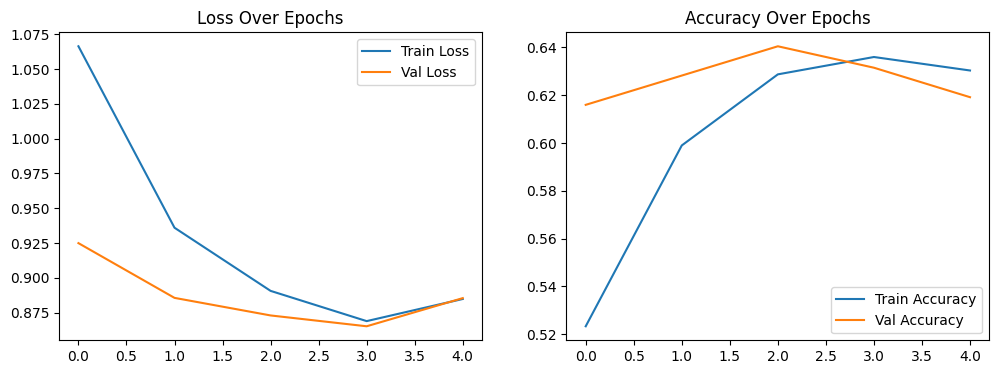

In [ ]:
# Plot Training Loss & Accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.title("Loss Over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Val Accuracy")
plt.title("Accuracy Over Epochs")
plt.legend()

plt.show()

In [ ]:
# Evaluate Model on Test Set
y_test_pred = model.predict(X_test_pad)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

# Evaluate Model on Training Set
y_train_pred = model.predict(X_train_pad)
y_train_pred_classes = np.argmax(y_train_pred, axis=1)

391/391 ━━━━━━━━━━━━━━━━━━━━ 17s 42ms/step
911/911 ━━━━━━━━━━━━━━━━━━━━ 36s 39ms/step



Training Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.81      0.65      8454
           1       0.67      0.43      0.52     10898
           2       0.75      0.71      0.73      9797

    accuracy                           0.64     29149
   macro avg       0.65      0.65      0.63     29149
weighted avg       0.66      0.64      0.63     29149



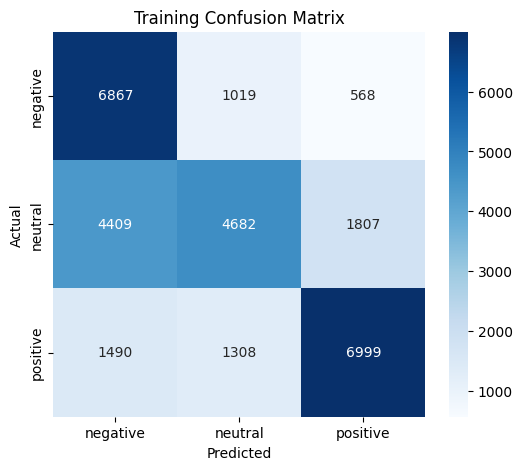

In [ ]:
# Classification Report (Training)
print("\nTraining Classification Report:")
print(classification_report(y_train, y_train_pred_classes))

# Confusion Matrix (Training)
cm_train = confusion_matrix(y_train, y_train_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_train, annot=True, fmt='d', cmap="Blues", xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Training Confusion Matrix")
plt.show()


Test Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.81      0.65      3714
           1       0.66      0.43      0.52      4608
           2       0.72      0.70      0.71      4171

    accuracy                           0.63     12493
   macro avg       0.64      0.65      0.63     12493
weighted avg       0.65      0.63      0.62     12493



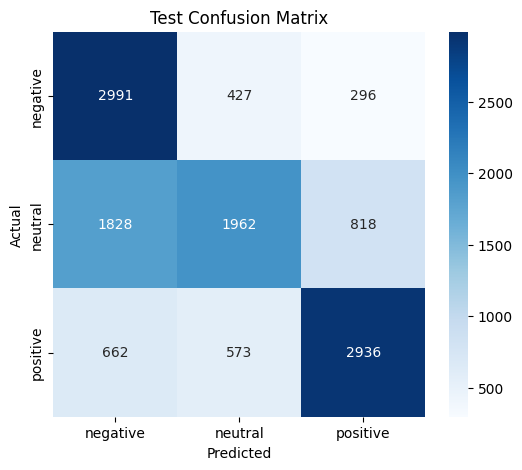

In [ ]:
# Classification Report (Test)
print("\nTest Classification Report:")
print(classification_report(y_test, y_test_pred_classes))

# Confusion Matrix (Test)
cm_test = confusion_matrix(y_test, y_test_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_test, annot=True, fmt='d', cmap="Blues", xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Test Confusion Matrix")
plt.show()

# Multinomial Naive Bayes & Complement Naive Bayes

## Multinomial Naive Bayes

In [43]:
import string
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from google.colab import files
uploaded = files.upload()

filename = list(uploaded.keys())[0]

#Read in data
df = pd.read_csv(filename)

Saving OriginalData.csv to OriginalData (2).csv


In [44]:
df.head()

,id,text,label,sentiment
0,9235,getting cds ready for tour,1,neutral
1,16790,"MC, happy mother`s day to your mom ;).. love yah",2,positive
2,24840,A year from now is graduation....i am pretty s...,0,negative
3,20744,because you had chips and sale w/o me,1,neutral
4,6414,Great for organising my work life balance,2,positive


In [45]:
stopwords = ['a', 'about', 'above', 'after', 'again', 'against', 'all', 'am', 'an', 'and', 'any', 'are', "aren't", 'as', 'at',
 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by',
 'can', "can't", 'cannot', 'could', "couldn't", 'did', "didn't", 'do', 'does', "doesn't", 'doing', "don't", 'down', 'during',
 'each', 'few', 'for', 'from', 'further',
 'had', "hadn't", 'has', "hasn't", 'have', "haven't", 'having', 'he', "he'd", "he'll", "he's", 'her', 'here', "here's",
 'hers', 'herself', 'him', 'himself', 'his', 'how', "how's",
 'i', "i'd", "i'll", "i'm", "i've", 'if', 'in', 'into', 'is', "isn't", 'it', "it's", 'its', 'itself',
 "let's", 'me', 'more', 'most', "mustn't", 'my', 'myself',
 'no', 'nor', 'not', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'ought', 'our', 'ours' 'ourselves', 'out', 'over', 'own',
 'same', "shan't", 'she', "she'd", "she'll", "she's", 'should', "shouldn't", 'so', 'some', 'such',
 'than', 'that',"that's", 'the', 'their', 'theirs', 'them', 'themselves', 'then', 'there', "there's", 'these', 'they', "they'd",
 "they'll", "they're", "they've", 'this', 'those', 'through', 'to', 'too', 'under', 'until', 'up', 'very',
 'was', "wasn't", 'we', "we'd", "we'll", "we're", "we've", 'were', "weren't", 'what', "what's", 'when', "when's", 'where',
 "where's", 'which', 'while', 'who', "who's", 'whom', 'why', "why's",'will', 'with', "won't", 'would', "wouldn't",
 'you', "you'd", "you'll", "you're", "you've", 'your', 'yours', 'yourself', 'yourselves',
 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'hundred', 'thousand', '1st', '2nd', '3rd',
 '4th', '5th', '6th', '7th', '8th', '9th', '10th']

In [46]:
#function to preprocess the words list to remove punctuations

def preprocess(words):
    #we'll make use of python's translate function,that maps one set of characters to another
    #we create an empty mapping table, the third argument allows us to list all of the characters
    #to remove during the translation process

    df['text'] = df['text'].astype(str).fillna("").apply(preprocess)
    df['label'] = df['label'].astype('category').cat.codes

    # filter out some unnecessary data like tabs
    words = [re.sub(r'\s+', ' ', word).strip() for word in words]

    #  Remove punctuation (except apostrophes to preserve contractions like don't, isn't)
    punctuations = string.punctuation.replace("'", "")
    trans_table = str.maketrans('', '', punctuations)
    words = [word.translate(trans_table) for word in words]

    # Handle words with leading/trailing apostrophes
    words = [word.strip("'") for word in words]

    # Remove purely numeric words (e.g., "1234", "2022")
    words = [word for word in words if not word.isdigit()]

    # Remove single-character words (they are usually not meaningful)
    words = [word for word in words if len(word) > 1]

    # Normalize words to lowercase
    words = [word.lower() for word in words]

    # Remove words shorter than 3 characters (correcting the original mistake)
    words = [word for word in words if len(word) > 2]

    return words


In [47]:
#function to remove stopwords

def remove_stopwords(words):
    words = [word for word in words if not word in stopwords]
    return words


#function to convert a sentence into list of words

def tokenize_sentence(line):
    words = line.strip().split()
    words = remove_stopwords(words)
    words = preprocess(words)

    return words


#function to remove metadata

def remove_metadata(lines):
    start = 0
    for i in range(len(lines)):
        if(lines[i].strip() == ""):
            start = i+1
            break
    new_lines = lines[start:]
    return new_lines

In [48]:
# Split Data into Training & Testing Sets
X_train, X_test, Y_train, Y_test = train_test_split(df['text'], df['sentiment'], test_size=0.3, random_state=42)

In [49]:
# Convert text value into string
X_train = X_train.fillna("").astype(str)
X_test = X_test.fillna("").astype(str)

vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)
# Train Naïve Bayes Model
clf = MultinomialNB()
clf.fit(X_train_vec, Y_train)



MultinomialNB()

### Classification Report and Confusion Matrix (Test)

Multinomial Naive Bayes Test Accuracy: 0.63

Classification Report:
               precision    recall  f1-score   support

    negative       0.70      0.52      0.60      3647
     neutral       0.54      0.70      0.61      4655
    positive       0.73      0.66      0.69      4191

    accuracy                           0.63     12493
   macro avg       0.66      0.63      0.63     12493
weighted avg       0.65      0.63      0.63     12493



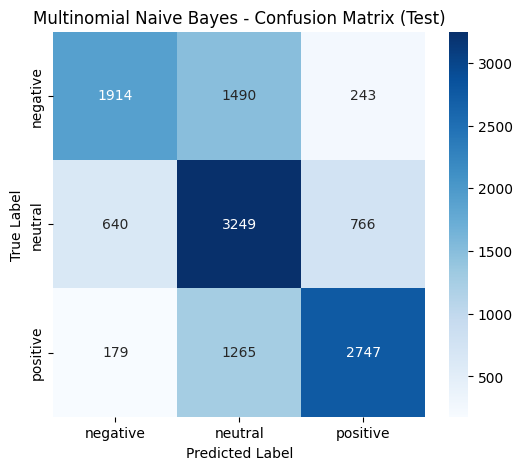

In [50]:
# Predict
Y_predict = clf.predict(X_test_vec)

# Evaluate
accuracy_test_mnb = accuracy_score(Y_test, Y_predict)
report_test_mnb = classification_report(Y_test, Y_predict)
cm_test_mnb = confusion_matrix(Y_test, Y_predict)

print(f"Multinomial Naive Bayes Test Accuracy: {accuracy_test_mnb:.2f}")
print("\nClassification Report:\n", report_test_mnb)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_test_mnb, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(Y_test), yticklabels=np.unique(Y_test))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Multinomial Naive Bayes - Confusion Matrix (Test)")
plt.show()

### Classification Report and Confusion Matrix (Train)

Training Accuracy: 0.71

Training Classification Report:
               precision    recall  f1-score   support

    negative       0.78      0.61      0.68      8521
     neutral       0.62      0.78      0.69     10852
    positive       0.79      0.72      0.75      9777

    accuracy                           0.71     29150
   macro avg       0.73      0.70      0.71     29150
weighted avg       0.72      0.71      0.71     29150



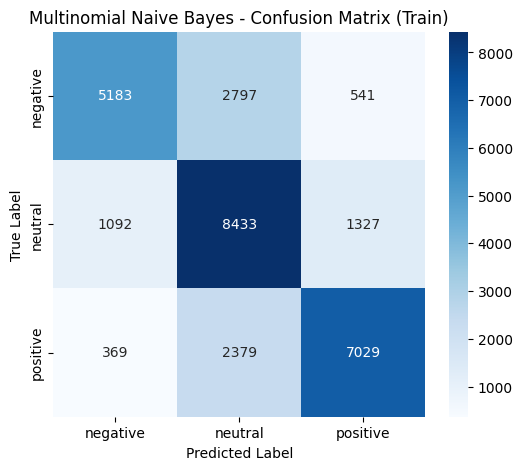

In [51]:
Y_train_predict = clf.predict(X_train_vec)

# Evaluate Training Performance
accuracy_train_mnb = accuracy_score(Y_train, Y_train_predict)
report_train_mnb = classification_report(Y_train, Y_train_predict)
cm_train_mnb = confusion_matrix(Y_train, Y_train_predict)

print(f"Training Accuracy: {accuracy_train_mnb:.2f}")
print("\nTraining Classification Report:\n", report_train_mnb)

# Plot Training Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_train_mnb, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(Y_train), yticklabels=np.unique(Y_train))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Multinomial Naive Bayes - Confusion Matrix (Train)")
plt.show()

## Complement Naive Bayes

In [52]:
clf_cnb = ComplementNB()
clf_cnb.fit(X_train_vec, Y_train) # Train on training data

ComplementNB()

### Classification Report and Confusion Matrix (Test)

Complement Naïve Bayes Test Accuracy: 0.64

Classification Report:
               precision    recall  f1-score   support

    negative       0.61      0.71      0.66      3647
     neutral       0.61      0.49      0.55      4655
    positive       0.69      0.74      0.71      4191

    accuracy                           0.64     12493
   macro avg       0.64      0.65      0.64     12493
weighted avg       0.64      0.64      0.63     12493



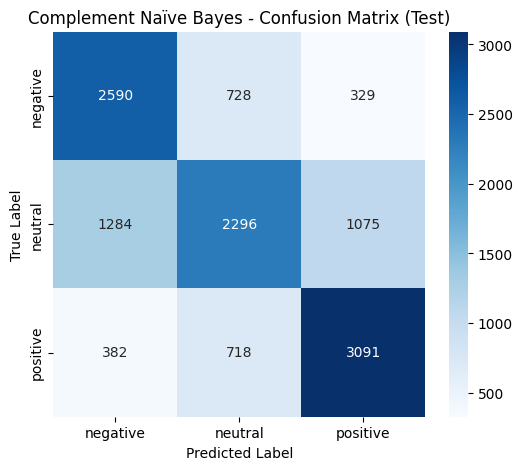

In [53]:
# Predict on test data
Y_predict_cnb = clf_cnb.predict(X_test_vec)

# Evaluate model
accuracy_test_cnb = accuracy_score(Y_test, Y_predict_cnb)
report_test_cnb = classification_report(Y_test, Y_predict_cnb)
cm_test_cnb = confusion_matrix(Y_test, Y_predict_cnb)

print(f"Complement Naïve Bayes Test Accuracy: {accuracy_test_cnb:.2f}")
print("\nClassification Report:\n", report_test_cnb)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_test_cnb, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(Y_test), yticklabels=np.unique(Y_test))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Complement Naïve Bayes - Confusion Matrix (Test)")
plt.show()

### Classification Report and Confusion Matrix (Train)

Complement Naïve Bayes Training Accuracy: 0.71

Training Classification Report:
               precision    recall  f1-score   support

    negative       0.78      0.61      0.68      8521
     neutral       0.62      0.78      0.69     10852
    positive       0.79      0.72      0.75      9777

    accuracy                           0.71     29150
   macro avg       0.73      0.70      0.71     29150
weighted avg       0.72      0.71      0.71     29150



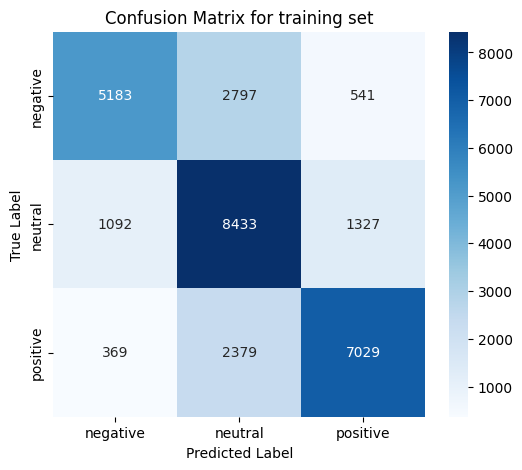

In [54]:
clf_cnb = ComplementNB()
clf_cnb.fit(X_train_vec, Y_train)

# Predict on train data
Y_predict_cnb = clf_cnb.predict(X_train_vec)

# Evaluate model
accuracy_train_cnb = accuracy_score(Y_train, Y_train_predict)
report_train_cnb = classification_report(Y_train, Y_train_predict)
cm_train_cnb = confusion_matrix(Y_train, Y_train_predict)

print(f"Complement Naïve Bayes Training Accuracy: {accuracy_train_cnb:.2f}")
print("\nTraining Classification Report:\n", report_train_cnb)

# Plot Training Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_train_cnb, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(Y_train), yticklabels=np.unique(Y_train))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for training set")
plt.show()

## Comparison between Multinomial Naive Bayes and Complement Naive Bayes

In [56]:
print(f"MultinomialNB - Train Accuracy: {accuracy_train_mnb:.2f}, Test Accuracy: {accuracy_test_mnb:.2f}")
print(f"ComplementNB - Train Accuracy: {accuracy_train_cnb:.2f}, Test Accuracy: {accuracy_test_cnb:.2f}")

MultinomialNB - Train Accuracy: 0.71, Test Accuracy: 0.63
ComplementNB - Train Accuracy: 0.71, Test Accuracy: 0.64


In [57]:
print(df['sentiment'].value_counts())


sentiment
neutral     15507
positive    13968
negative    12168
Name: count, dtype: int64
